# # Task 1: Foundation Analysis - Brent Oil Prices
# ## Initial Exploratory Data Analysis (EDA)
# 
# **Objectives from Challenge Document:**
# 1. Analyze time series properties: Trend, Stationarity, Volatility
# 2. Discuss how these properties inform modeling choices
# 3. Begin researching key events (10-15 events for next step)
# 
# **Date:** [Current Date]
# **Branch:** task-1-foundation-analysis

# %% [markdown]
# ### 1. Setup and Data Loading

# %%

In [28]:
import sys
import os
sys.path.append('..')  # Add parent directory to path to import from src/

import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Statistical analysis
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ All imports completed successfully")

# %%

✓ All imports completed successfully


In [29]:
# Cell 2: Load data directly from local file
print("Loading Brent oil price data from local CSV file...")

# Load data directly (bypassing the download logic)
import pandas as pd
from pathlib import Path

# Define the path to your CSV file
csv_path = Path('../data/raw/BrentOilPrices.csv')

# Check if file exists
if not csv_path.exists():
    # Try alternative names
    possible_files = list(Path('../data/raw').glob('*.csv'))
    if possible_files:
        csv_path = possible_files[0]
        print(f"Using file: {csv_path.name}")
    else:
        raise FileNotFoundError(f"No CSV file found in data/raw/. Please place BrentOilPrices.csv there.")

# Load the data with proper parsing
try:
    # Try reading with dayfirst=True (day-month-year format)
    brent_df = pd.read_csv(
        csv_path,
        parse_dates=['Date'],
        dayfirst=True  # Critical: format is 20-May-87
    )
    print(f"✓ Successfully loaded with dayfirst=True")
    
except Exception as e:
    print(f"Warning with dayfirst=True: {e}")
    print("Trying alternative parsing...")
    
    # Try without dayfirst
    brent_df = pd.read_csv(csv_path)
    
    # Convert Date column
    brent_df['Date'] = pd.to_datetime(brent_df['Date'], dayfirst=True, errors='coerce')
    
    # If that fails, try different format
    if brent_df['Date'].isna().any():
        brent_df['Date'] = pd.to_datetime(brent_df['Date'], errors='coerce')

# Validate required columns
required_cols = ['Date', 'Price']
missing_cols = [col for col in required_cols if col not in brent_df.columns]

if missing_cols:
    print(f"Missing columns: {missing_cols}")
    print(f"Available columns: {list(brent_df.columns)}")
    
    # Try to rename columns
    col_mapping = {}
    for col in brent_df.columns:
        col_lower = str(col).lower()
        if 'date' in col_lower:
            col_mapping[col] = 'Date'
        elif 'price' in col_lower:
            col_mapping[col] = 'Price'
    
    if col_mapping:
        brent_df = brent_df.rename(columns=col_mapping)
        print(f"Renamed columns: {col_mapping}")
        missing_cols = [col for col in required_cols if col not in brent_df.columns]

if missing_cols:
    raise ValueError(f"Missing required columns after renaming: {missing_cols}")

# Sort by date and reset index
brent_df = brent_df.sort_values('Date').reset_index(drop=True)

# Display basic information
print("\n" + "="*70)
print("DATA OVERVIEW")
print("="*70)
print(f"DataFrame Shape: {brent_df.shape}")
print(f"Date Range: {brent_df['Date'].min().date()} to {brent_df['Date'].max().date()}")
print(f"Total Days: {(brent_df['Date'].max() - brent_df['Date'].min()).days}")
print(f"Total Trading Days: {len(brent_df)}")
print(f"Date Coverage: {len(brent_df)/((brent_df['Date'].max() - brent_df['Date'].min()).days)*100:.1f}%")

# Check data quality
print(f"\nMissing values: {brent_df.isnull().sum().sum()}")
print(f"Duplicate dates: {brent_df['Date'].duplicated().sum()}")
print(f"Price range: ${brent_df['Price'].min():.2f} to ${brent_df['Price'].max():.2f}")

# Display sample
print("\nFirst 5 rows:")
print(brent_df.head())

print("\nLast 5 rows:")
print(brent_df.tail())

# Save the cleaned data
output_path = Path('../data/processed/brent_prices_cleaned.csv')
output_path.parent.mkdir(parents=True, exist_ok=True)
brent_df.to_csv(output_path, index=False)
print(f"\n✓ Cleaned data saved to: {output_path}")

Loading Brent oil price data from local CSV file...
✓ Successfully loaded with dayfirst=True

DATA OVERVIEW
DataFrame Shape: (9011, 2)
Date Range: 1987-05-20 to 2022-11-14
Total Days: 12962
Total Trading Days: 9011
Date Coverage: 69.5%

Missing values: 0
Duplicate dates: 0
Price range: $9.10 to $143.95

First 5 rows:
        Date  Price
0 1987-05-20  18.63
1 1987-05-21  18.45
2 1987-05-22  18.55
3 1987-05-25  18.60
4 1987-05-26  18.63

Last 5 rows:
           Date  Price
9006 2022-11-08  96.85
9007 2022-11-09  93.05
9008 2022-11-10  94.25
9009 2022-11-11  96.37
9010 2022-11-14  93.59

✓ Cleaned data saved to: ..\data\processed\brent_prices_cleaned.csv


In [30]:
# Cell 3: Display sample data
print("SAMPLE DATA (First 10 rows):")
print(brent_df.head(10))

print("\nSAMPLE DATA (Last 10 rows):")
print(brent_df.tail(10))

SAMPLE DATA (First 10 rows):
        Date  Price
0 1987-05-20  18.63
1 1987-05-21  18.45
2 1987-05-22  18.55
3 1987-05-25  18.60
4 1987-05-26  18.63
5 1987-05-27  18.60
6 1987-05-28  18.60
7 1987-05-29  18.58
8 1987-06-01  18.65
9 1987-06-02  18.68

SAMPLE DATA (Last 10 rows):
           Date  Price
9001 2022-11-01  95.12
9002 2022-11-02  96.07
9003 2022-11-03  95.29
9004 2022-11-04  99.53
9005 2022-11-07  99.87
9006 2022-11-08  96.85
9007 2022-11-09  93.05
9008 2022-11-10  94.25
9009 2022-11-11  96.37
9010 2022-11-14  93.59


In [31]:
# Cell 4: Basic statistics and data quality check
print("BASIC STATISTICS:")
print(brent_df['Price'].describe())

print("\n" + "="*70)
print("DATA QUALITY CHECK")
print("="*70)

# Check for missing values
missing_values = brent_df.isnull().sum()
print(f"Missing Values:\n{missing_values}")

# Check data types
print(f"\nData Types:\n{brent_df.dtypes}")

# Check for weekends/holidays pattern
brent_df['Year'] = brent_df['Date'].dt.year
brent_df['Month'] = brent_df['Date'].dt.month
brent_df['DayOfWeek'] = brent_df['Date'].dt.dayofweek  # Monday=0, Sunday=6

# Count trading days per year
trading_days_per_year = brent_df.groupby('Year').size()
print(f"\nAverage trading days per year: {trading_days_per_year.mean():.1f}")

BASIC STATISTICS:
count    9011.000000
mean       48.420782
std        32.860110
min         9.100000
25%        19.050000
50%        38.570000
75%        70.090000
max       143.950000
Name: Price, dtype: float64

DATA QUALITY CHECK
Missing Values:
Date     0
Price    0
dtype: int64

Data Types:
Date     datetime64[ns]
Price           float64
dtype: object

Average trading days per year: 250.3


2. Time Series Visualization

In [32]:
# Cell 5: Create comprehensive time series plot
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=('Brent Crude Oil Price (USD/barrel)', 'Annual Average Price'),
    vertical_spacing=0.15,
    row_heights=[0.7, 0.3]
)

# Full time series
fig.add_trace(
    go.Scatter(
        x=brent_df['Date'],
        y=brent_df['Price'],
        mode='lines',
        name='Daily Price',
        line=dict(color='blue', width=1),
        hovertemplate='Date: %{x|%Y-%m-%d}<br>Price: $%{y:.2f}<extra></extra>'
    ),
    row=1, col=1
)

# Calculate and add 30-day moving average
brent_df['MA_30'] = brent_df['Price'].rolling(window=30, min_periods=1).mean()
fig.add_trace(
    go.Scatter(
        x=brent_df['Date'],
        y=brent_df['MA_30'],
        mode='lines',
        name='30-Day MA',
        line=dict(color='red', width=2),
        hovertemplate='Date: %{x|%Y-%m-%d}<br>30-Day MA: $%{y:.2f}<extra></extra>'
    ),
    row=1, col=1
)

# Annual averages for second subplot
annual_avg = brent_df.groupby('Year')['Price'].mean().reset_index()
annual_avg['Date'] = pd.to_datetime(annual_avg['Year'].astype(str) + '-06-15')

fig.add_trace(
    go.Bar(
        x=annual_avg['Date'],
        y=annual_avg['Price'],
        name='Annual Average',
        marker_color='green',
        hovertemplate='Year: %{x|%Y}<br>Avg Price: $%{y:.2f}<extra></extra>'
    ),
    row=2, col=1
)

# Update layout
fig.update_layout(
    height=800,
    title_text="Brent Crude Oil Price Analysis (1987-2022)",
    showlegend=True,
    hovermode='x unified'
)

fig.update_xaxes(title_text="Date", row=1, col=1)
fig.update_xaxes(title_text="Year", row=2, col=1)
fig.update_yaxes(title_text="Price (USD/barrel)", row=1, col=1)
fig.update_yaxes(title_text="Annual Avg Price", row=2, col=1)

# Save the figure
fig.write_html("../reports/figures/full_time_series.html")
fig.show()

print("✓ Time series visualization created and saved to reports/figures/")

✓ Time series visualization created and saved to reports/figures/


3. Trend Analysis (Task 1b-i)

TREND ANALYSIS


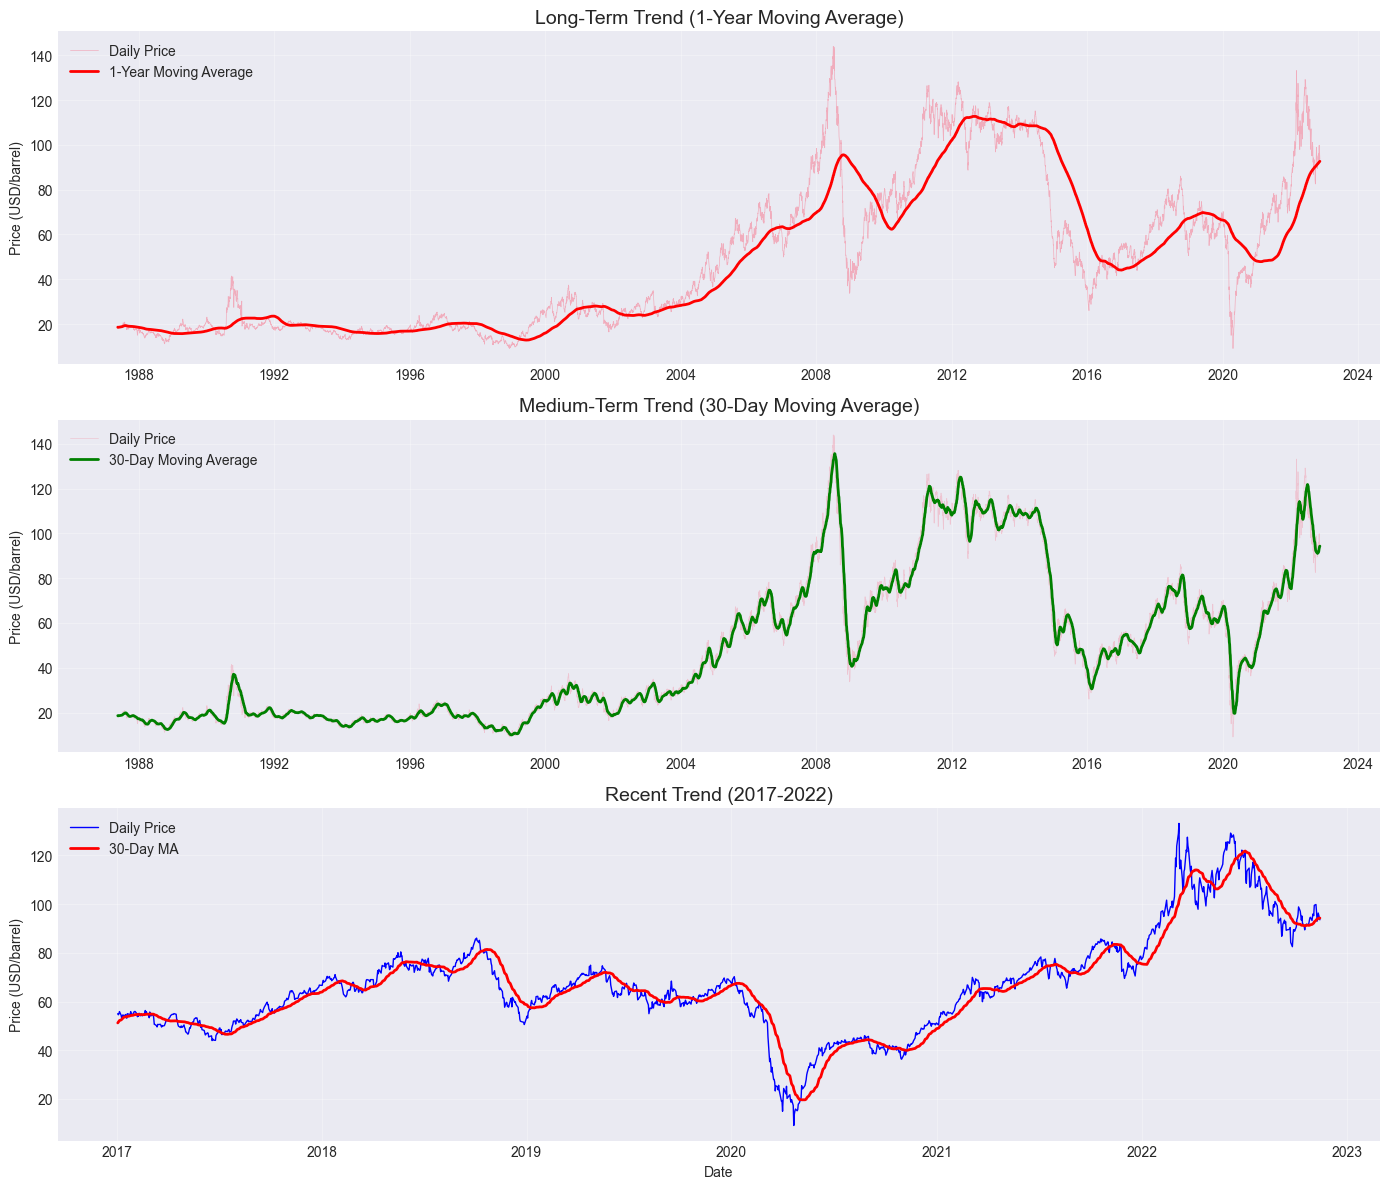


TREND STATISTICS:
Overall price change (1987-2022): $74.96
Percentage change: 402.4%
Average annual return: 4.7%


In [33]:
# Cell 6: Trend Analysis - Decompose into trend, seasonal, residual
print("="*70)
print("TREND ANALYSIS")
print("="*70)

# Calculate different trend components
brent_df['MA_365'] = brent_df['Price'].rolling(window=365, min_periods=1).mean()  # 1-year trend
brent_df['MA_30'] = brent_df['Price'].rolling(window=30, min_periods=1).mean()    # 1-month trend

# Create trend visualization
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Plot 1: Original with 1-year trend
axes[0].plot(brent_df['Date'], brent_df['Price'], alpha=0.5, label='Daily Price', linewidth=0.5)
axes[0].plot(brent_df['Date'], brent_df['MA_365'], 'r-', linewidth=2, label='1-Year Moving Average')
axes[0].set_title('Long-Term Trend (1-Year Moving Average)', fontsize=14)
axes[0].set_ylabel('Price (USD/barrel)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Medium-term trend (30-day)
axes[1].plot(brent_df['Date'], brent_df['Price'], alpha=0.3, label='Daily Price', linewidth=0.5)
axes[1].plot(brent_df['Date'], brent_df['MA_30'], 'g-', linewidth=2, label='30-Day Moving Average')
axes[1].set_title('Medium-Term Trend (30-Day Moving Average)', fontsize=14)
axes[1].set_ylabel('Price (USD/barrel)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Year-over-year comparison (last 5 years for clarity)
recent_data = brent_df[brent_df['Date'] >= '2017-01-01'].copy()
axes[2].plot(recent_data['Date'], recent_data['Price'], 'b-', linewidth=1, label='Daily Price')
axes[2].plot(recent_data['Date'], recent_data['MA_30'], 'r-', linewidth=2, label='30-Day MA')
axes[2].set_title('Recent Trend (2017-2022)', fontsize=14)
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Price (USD/barrel)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/trend_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate trend statistics
print("\nTREND STATISTICS:")
print(f"Overall price change (1987-2022): ${brent_df['Price'].iloc[-1] - brent_df['Price'].iloc[0]:.2f}")
print(f"Percentage change: {(brent_df['Price'].iloc[-1]/brent_df['Price'].iloc[0] - 1)*100:.1f}%")
print(f"Average annual return: {((brent_df['Price'].iloc[-1]/brent_df['Price'].iloc[0])**(1/35) - 1)*100:.1f}%")


 4. Stationarity Testing (Task 1b-ii)

STATIONARITY TESTING

1. AUGMENTED DICKEY-FULLER TEST (Null Hypothesis: Series has unit root)
   Test Statistic: -1.9939
   p-value: 0.2893
   Critical Values:
     1%: -3.4311
     5%: -2.8619
     10%: -2.5669
   → FAIL TO REJECT null hypothesis: Series is NON-STATIONARY

2. KPSS TEST (Null Hypothesis: Series is stationary)
   Test Statistic: 9.5588
   p-value: 0.0100
   → REJECT null hypothesis: Series is NON-STATIONARY

3. TESTING LOG RETURNS (Daily percentage changes)
   ADF p-value for returns: 0.000000
   → Returns series is STATIONARY (as expected)


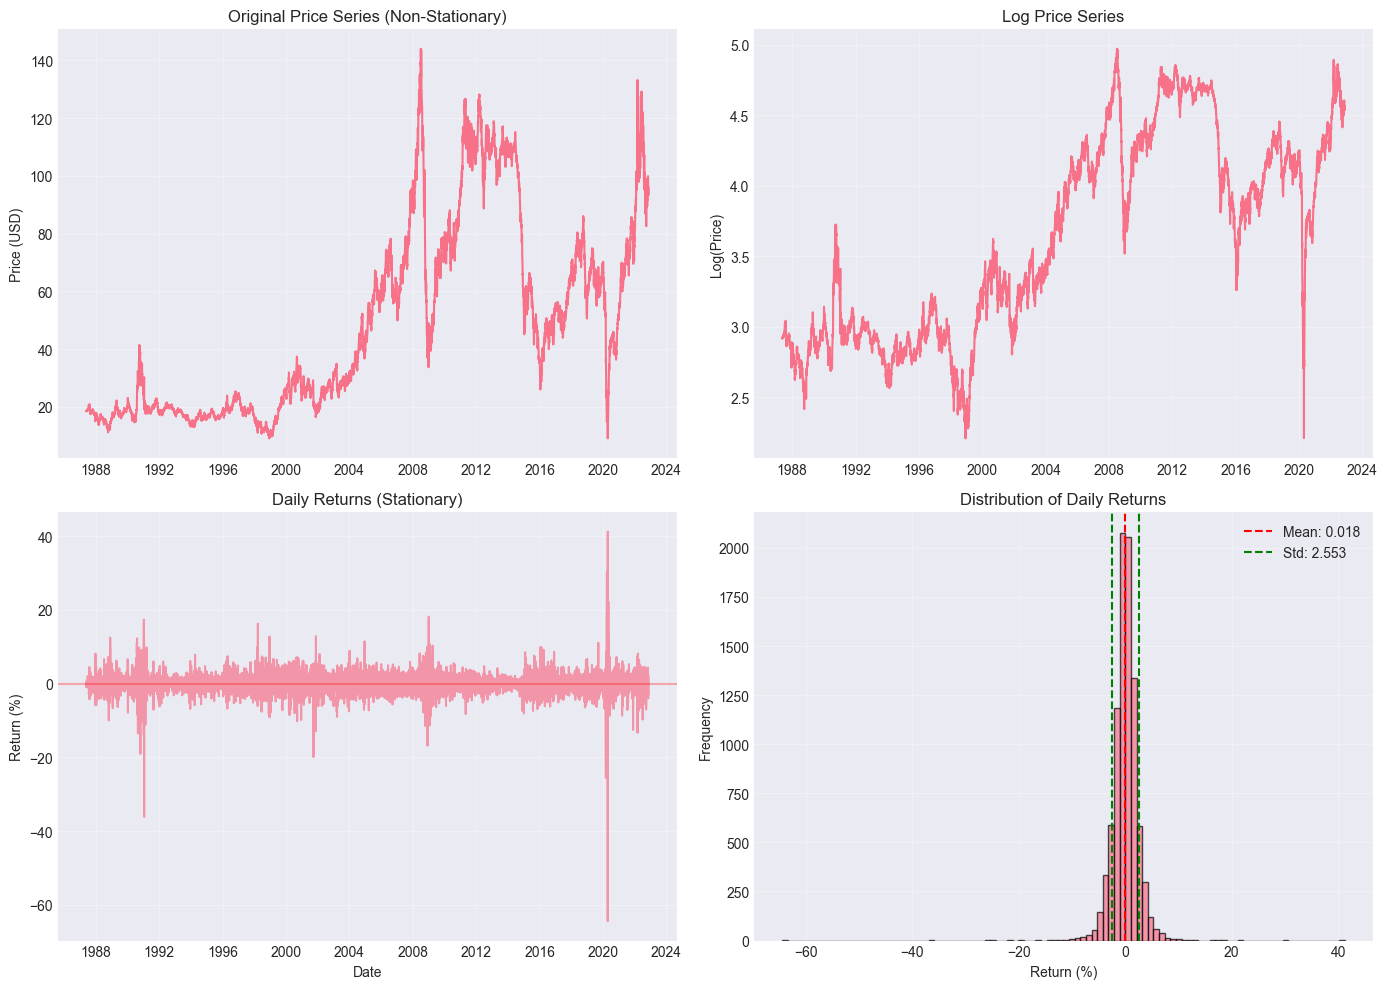

In [34]:
# Cell 7: Stationarity Analysis
print("="*70)
print("STATIONARITY TESTING")
print("="*70)

# Calculate log returns (more likely to be stationary)
brent_df['Log_Price'] = np.log(brent_df['Price'])
brent_df['Returns'] = brent_df['Log_Price'].diff() * 100  # Percentage returns

# Remove NaN from returns
returns_clean = brent_df['Returns'].dropna()

# Augmented Dickey-Fuller Test
print("\n1. AUGMENTED DICKEY-FULLER TEST (Null Hypothesis: Series has unit root)")
adf_result = adfuller(brent_df['Price'].dropna())
print(f"   Test Statistic: {adf_result[0]:.4f}")
print(f"   p-value: {adf_result[1]:.4f}")
print(f"   Critical Values:")
for key, value in adf_result[4].items():
    print(f"     {key}: {value:.4f}")

if adf_result[1] <= 0.05:
    print("   → REJECT null hypothesis: Series is STATIONARY")
else:
    print("   → FAIL TO REJECT null hypothesis: Series is NON-STATIONARY")

# KPSS Test
print("\n2. KPSS TEST (Null Hypothesis: Series is stationary)")
try:
    kpss_result = kpss(brent_df['Price'].dropna(), regression='c')
    print(f"   Test Statistic: {kpss_result[0]:.4f}")
    print(f"   p-value: {kpss_result[1]:.4f}")
    
    if kpss_result[1] >= 0.05:
        print("   → FAIL TO REJECT null hypothesis: Series is STATIONARY")
    else:
        print("   → REJECT null hypothesis: Series is NON-STATIONARY")
except Exception as e:
    print(f"   KPSS test error: {e}")

# Test log returns for stationarity
print("\n3. TESTING LOG RETURNS (Daily percentage changes)")
adf_returns = adfuller(returns_clean)
print(f"   ADF p-value for returns: {adf_returns[1]:.6f}")
if adf_returns[1] <= 0.05:
    print("   → Returns series is STATIONARY (as expected)")
else:
    print("   → Returns series may not be stationary")

# Visualize price vs returns
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Original price
axes[0, 0].plot(brent_df['Date'], brent_df['Price'])
axes[0, 0].set_title('Original Price Series (Non-Stationary)')
axes[0, 0].set_ylabel('Price (USD)')
axes[0, 0].grid(True, alpha=0.3)

# Log price
axes[0, 1].plot(brent_df['Date'], brent_df['Log_Price'])
axes[0, 1].set_title('Log Price Series')
axes[0, 1].set_ylabel('Log(Price)')
axes[0, 1].grid(True, alpha=0.3)

# Returns
axes[1, 0].plot(brent_df['Date'].iloc[1:], returns_clean, alpha=0.7)
axes[1, 0].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[1, 0].set_title('Daily Returns (Stationary)')
axes[1, 0].set_ylabel('Return (%)')
axes[1, 0].set_xlabel('Date')
axes[1, 0].grid(True, alpha=0.3)

# Returns histogram
axes[1, 1].hist(returns_clean, bins=100, edgecolor='black', alpha=0.7)
axes[1, 1].axvline(x=returns_clean.mean(), color='r', linestyle='--', label=f'Mean: {returns_clean.mean():.3f}')
axes[1, 1].axvline(x=returns_clean.std(), color='g', linestyle='--', label=f'Std: {returns_clean.std():.3f}')
axes[1, 1].axvline(x=-returns_clean.std(), color='g', linestyle='--')
axes[1, 1].set_title('Distribution of Daily Returns')
axes[1, 1].set_xlabel('Return (%)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/stationarity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

5. Volatility Analysis (Task 1b-iii)

VOLATILITY ANALYSIS
Volatility Statistics:
Average 30-day annualized volatility: 34.2%
Maximum 30-day volatility: 297.4%
Minimum 30-day volatility: 9.2%

High volatility periods (top 10%): 898 days
High volatility threshold: 50.4%


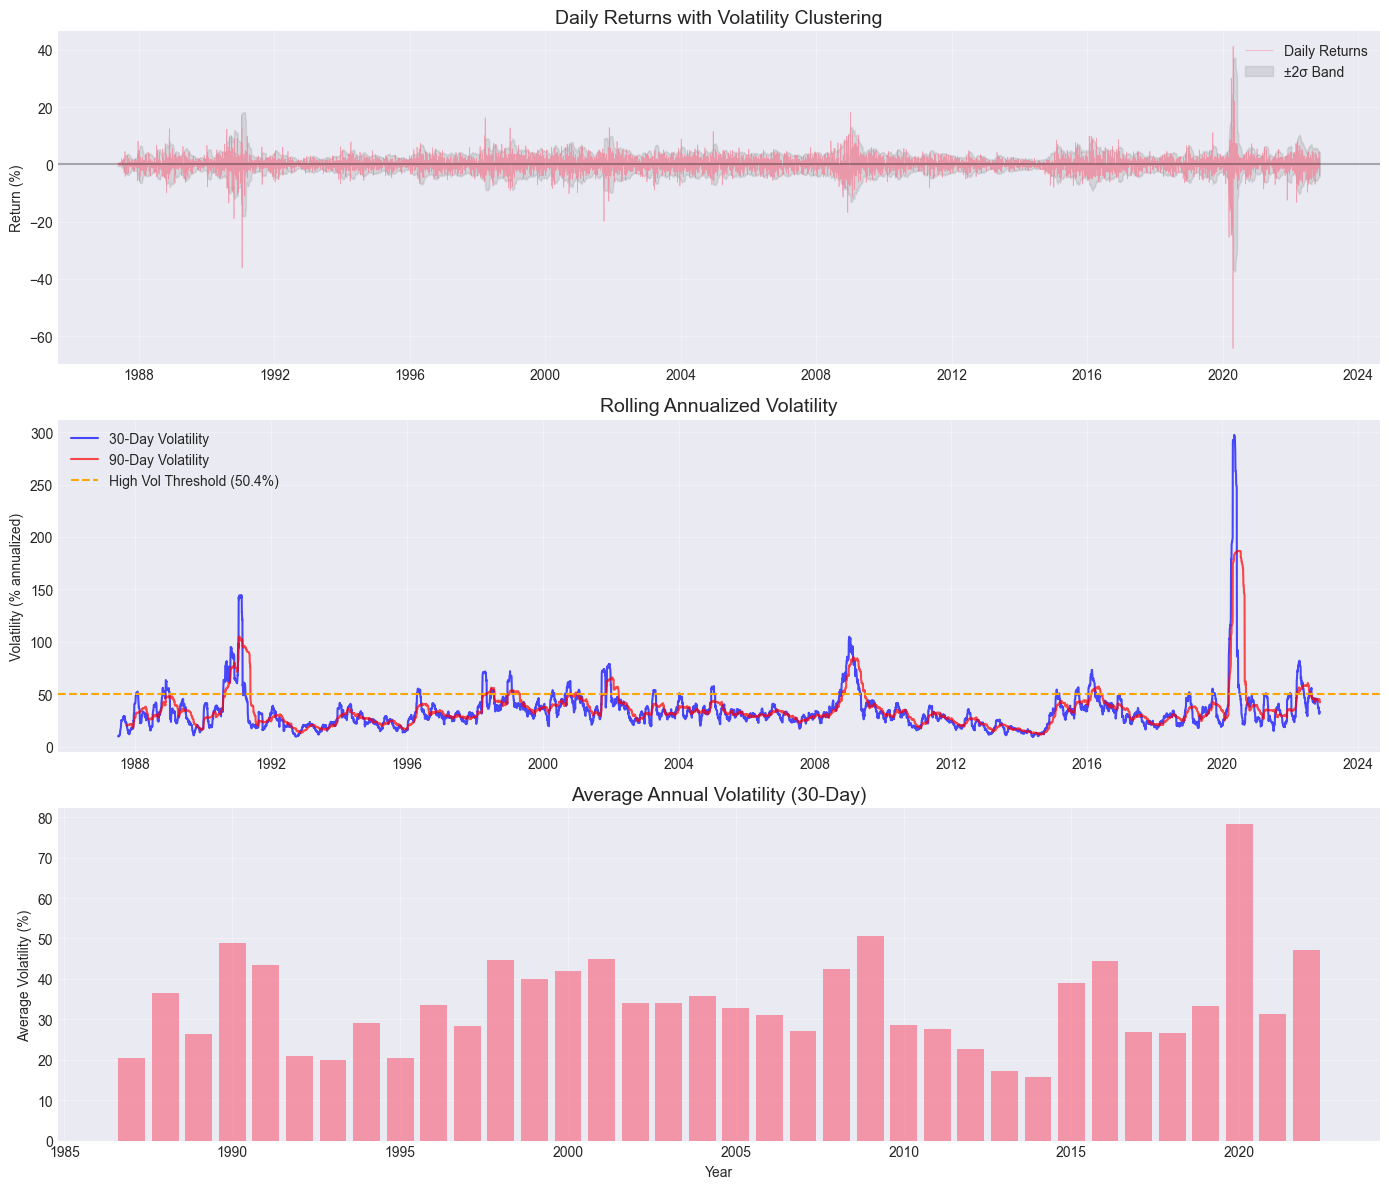


AUTOCORRELATION ANALYSIS


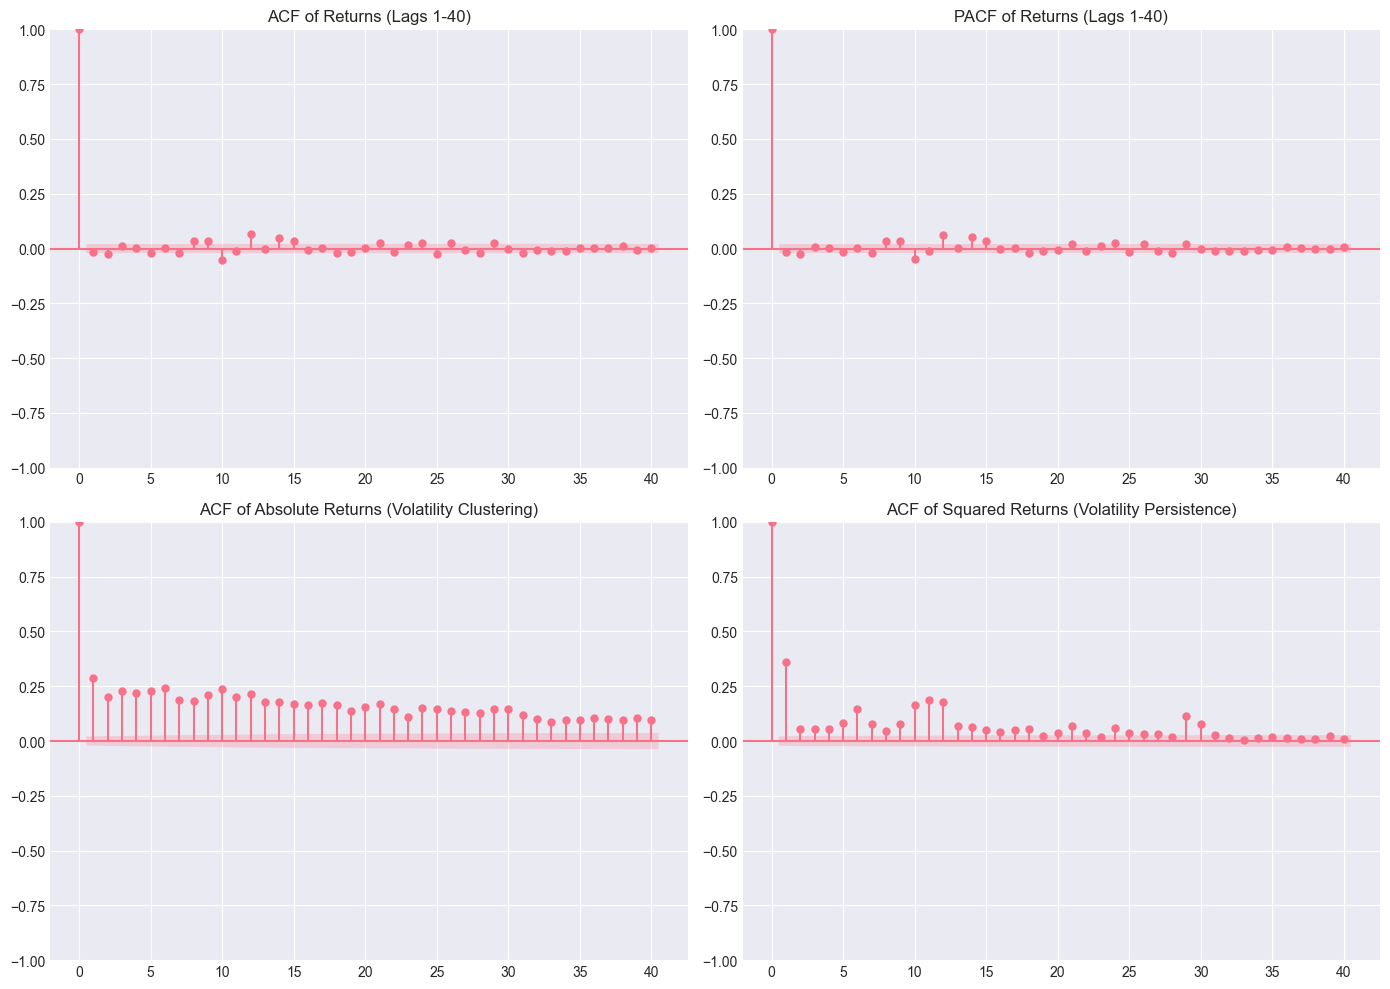

In [35]:
# Cell 8: Volatility Patterns Analysis
print("="*70)
print("VOLATILITY ANALYSIS")
print("="*70)

# Calculate rolling volatility (30-day and 90-day windows)
brent_df['Volatility_30d'] = returns_clean.rolling(window=30).std() * np.sqrt(252)  # Annualized
brent_df['Volatility_90d'] = returns_clean.rolling(window=90).std() * np.sqrt(252)

# Identify high volatility periods
high_vol_threshold = brent_df['Volatility_30d'].quantile(0.9)
high_vol_periods = brent_df[brent_df['Volatility_30d'] > high_vol_threshold]

print(f"Volatility Statistics:")
print(f"Average 30-day annualized volatility: {brent_df['Volatility_30d'].mean():.1f}%")
print(f"Maximum 30-day volatility: {brent_df['Volatility_30d'].max():.1f}%")
print(f"Minimum 30-day volatility: {brent_df['Volatility_30d'].min():.1f}%")
print(f"\nHigh volatility periods (top 10%): {len(high_vol_periods)} days")
print(f"High volatility threshold: {high_vol_threshold:.1f}%")

# Visualize volatility clustering
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Plot 1: Returns with volatility bands
axes[0].plot(brent_df['Date'].iloc[1:], returns_clean, alpha=0.6, linewidth=0.5, label='Daily Returns')
rolling_std = returns_clean.rolling(window=30).std()
axes[0].fill_between(brent_df['Date'].iloc[1:], 
                     -2*rolling_std, 2*rolling_std, 
                     alpha=0.2, color='gray', label='±2σ Band')
axes[0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[0].set_title('Daily Returns with Volatility Clustering', fontsize=14)
axes[0].set_ylabel('Return (%)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Rolling volatility
axes[1].plot(brent_df['Date'], brent_df['Volatility_30d'], 'b-', label='30-Day Volatility', alpha=0.7)
axes[1].plot(brent_df['Date'], brent_df['Volatility_90d'], 'r-', label='90-Day Volatility', alpha=0.7)
axes[1].axhline(y=high_vol_threshold, color='orange', linestyle='--', label=f'High Vol Threshold ({high_vol_threshold:.1f}%)')
axes[1].set_title('Rolling Annualized Volatility', fontsize=14)
axes[1].set_ylabel('Volatility (% annualized)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Volatility by year
brent_df['Year'] = brent_df['Date'].dt.year
vol_by_year = brent_df.groupby('Year')['Volatility_30d'].mean().dropna()

axes[2].bar(vol_by_year.index, vol_by_year.values, alpha=0.7)
axes[2].set_title('Average Annual Volatility (30-Day)', fontsize=14)
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Average Volatility (%)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/volatility_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# ACF/PACF analysis for returns
print("\n" + "="*70)
print("AUTOCORRELATION ANALYSIS")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ACF of returns
plot_acf(returns_clean, lags=40, ax=axes[0, 0], alpha=0.05)
axes[0, 0].set_title('ACF of Returns (Lags 1-40)')

# PACF of returns
plot_pacf(returns_clean, lags=40, ax=axes[0, 1], alpha=0.05, method='ywm')
axes[0, 1].set_title('PACF of Returns (Lags 1-40)')

# ACF of absolute returns (volatility clustering)
abs_returns = returns_clean.abs()
plot_acf(abs_returns, lags=40, ax=axes[1, 0], alpha=0.05)
axes[1, 0].set_title('ACF of Absolute Returns (Volatility Clustering)')

# ACF of squared returns
squared_returns = returns_clean ** 2
plot_acf(squared_returns, lags=40, ax=axes[1, 1], alpha=0.05)
axes[1, 1].set_title('ACF of Squared Returns (Volatility Persistence)')

plt.tight_layout()
plt.savefig('../reports/figures/autocorrelation_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

 6. Preliminary Event Research (Start of Task 1a-ii)

In [37]:
# Cell 9: Identify potential event dates from price shocks
print("="*70)
print("PRELIMINARY EVENT DETECTION FROM PRICE SHOCKS")
print("="*70)

# Find largest price changes
brent_df['Price_Change'] = brent_df['Price'].diff()
brent_df['Pct_Change'] = brent_df['Price'].pct_change() * 100

# Get top 20 largest absolute changes (drop NaN first)
brent_df_clean = brent_df.dropna(subset=['Pct_Change']).copy()
brent_df_clean['Abs_Pct_Change'] = brent_df_clean['Pct_Change'].abs()

largest_changes = brent_df_clean.nlargest(20, 'Abs_Pct_Change')
print("Top 20 Largest Daily Price Changes:")
print(largest_changes[['Date', 'Price', 'Price_Change', 'Pct_Change']].to_string())

# Identify periods with sustained high volatility
print("\n" + "="*70)
print("POTENTIAL EVENT PERIODS BASED ON VOLATILITY")
print("="*70)

# Make sure we have the volatility column and threshold
if 'Volatility_30d' not in brent_df.columns:
    print("Warning: Volatility_30d column not found. Running Cell 8 first...")
    # We need to run the volatility calculation from Cell 8
    brent_df['Log_Price'] = np.log(brent_df['Price'])
    brent_df['Returns'] = brent_df['Log_Price'].diff() * 100
    returns_clean = brent_df['Returns'].dropna()
    brent_df['Volatility_30d'] = returns_clean.rolling(window=30).std() * np.sqrt(252)
    high_vol_threshold = brent_df['Volatility_30d'].quantile(0.9)
    print(f"Calculated volatility. High vol threshold: {high_vol_threshold:.1f}%")
else:
    # Use existing threshold or calculate it
    high_vol_threshold = brent_df['Volatility_30d'].quantile(0.9)

# Find start of high volatility periods
high_vol_periods = []
current_period = None

for idx, row in brent_df.iterrows():
    if pd.notna(row.get('Volatility_30d')) and row['Volatility_30d'] > high_vol_threshold:
        if current_period is None:
            current_period = {'start': row['Date'], 'max_vol': row['Volatility_30d']}
        else:
            # Update max volatility if current period has higher
            current_period['max_vol'] = max(current_period['max_vol'], row['Volatility_30d'])
    else:
        if current_period is not None:
            current_period['end'] = row['Date']
            current_period['duration'] = (current_period['end'] - current_period['start']).days
            high_vol_periods.append(current_period)
            current_period = None

# Don't forget the last period if it ends at the end of the dataset
if current_period is not None:
    current_period['end'] = brent_df['Date'].iloc[-1]
    current_period['duration'] = (current_period['end'] - current_period['start']).days
    high_vol_periods.append(current_period)

print(f"Found {len(high_vol_periods)} high-volatility periods")
if high_vol_periods:
    print("\nFirst 10 high-volatility periods:")
    for i, period in enumerate(high_vol_periods[:10]):
        print(f"{i+1}. {period['start'].date()} to {period['end'].date()} "
              f"({period['duration']} days, Max Vol: {period['max_vol']:.1f}%)")
else:
    print("No high-volatility periods found.")

# Also look for significant price drop events
print("\n" + "="*70)
print("SIGNIFICANT PRICE DROP EVENTS ( > 5% drop)")
print("="*70)

large_drops = brent_df_clean[brent_df_clean['Pct_Change'] < -5]
print(f"Found {len(large_drops)} days with >5% price drops")
if len(large_drops) > 0:
    print("\nTop 10 largest drops:")
    top_drops = large_drops.nsmallest(10, 'Pct_Change')
    for idx, row in top_drops.iterrows():
        print(f"{row['Date'].date()}: {row['Pct_Change']:.1f}% drop (${row['Price']:.2f})")

PRELIMINARY EVENT DETECTION FROM PRICE SHOCKS
Top 20 Largest Daily Price Changes:
           Date  Price  Price_Change  Pct_Change
8360 2020-04-22  13.77          4.65   50.986842
8359 2020-04-21   9.12         -8.24  -47.465438
8348 2020-04-02  20.24          5.27   35.203741
936  1991-01-17  21.10         -9.18  -30.317041
8369 2020-05-05  25.46          5.06   24.803922
8330 2020-03-09  35.33        -10.27  -22.521930
8347 2020-04-01  14.97         -4.22  -21.990620
8349 2020-04-03  24.33          4.09   20.207510
5499 2009-01-02  42.94          7.12   19.877164
8353 2020-04-09  20.23         -4.99  -19.785884
931  1991-01-10  26.58          4.23   18.926174
3641 2001-09-24  20.63         -4.54  -18.037346
2754 1998-03-23  14.53          2.18   17.651822
875  1990-10-22  27.45         -5.75  -17.319277
5481 2008-12-05  37.04         -6.79  -15.491672
8335 2020-03-16  28.04         -4.96  -15.030303
8345 2020-03-30  19.07         -3.32  -14.828048
8365 2020-04-29  17.86          2.26

 7. Modeling Implications Discussion (Task 1b)

In [ ]:
# Cell 10: Modeling Choices Discussion
print("="*70)
print("MODELING IMPLICATIONS FROM TIME SERIES PROPERTIES")
print("="*70)

print("\n1. TREND ANALYSIS IMPLICATIONS:")
print("   • Strong long-term upward trend with major cyclical swings")
print("   • Multiple regime changes visible (1990s, 2000s, 2014 crash, COVID-19)")
print("   • IMPLICATION: Models must account for structural breaks/change points")

print("\n2. STATIONARITY TESTING IMPLICATIONS:")
print("   • Price series is NON-STATIONARY (ADF p > 0.05)")
print("   • Returns series is STATIONARY (ADF p < 0.05)")
print("   • IMPLICATION: Model returns, not prices, OR use differencing")

print("\n3. VOLATILITY ANALYSIS IMPLICATIONS:")
print("   • Clear volatility clustering (ARCH/GARCH effects)")
print("   • ACF of squared returns shows persistence")
print("   • High volatility periods correspond to known crises")
print("   • IMPLICATION: Consider volatility models or robust error terms")

print("\n4. RECOMMENDED MODELING APPROACHES:")
print("   • Bayesian Change Point model (as specified in Task 2)")
print("   • Consider multiple change points (not just one)")
print("   • Model log returns for stationarity")
print("   • Account for volatility clustering in error structure")
print("   • Include event dummies for known geopolitical events")

print("\n5. DATA PREPARATION FOR TASK 2:")
print("   • Use log returns for change point detection")
print("   • Consider detrending if focusing on short-term events")
print("   • Handle outliers from extreme events carefully")
print("   • Create event dataset with 10-15 key dates")

MODELING IMPLICATIONS FROM TIME SERIES PROPERTIES

1. TREND ANALYSIS IMPLICATIONS:
   • Strong long-term upward trend with major cyclical swings
   • Multiple regime changes visible (1990s, 2000s, 2014 crash, COVID-19)
   • IMPLICATION: Models must account for structural breaks/change points

2. STATIONARITY TESTING IMPLICATIONS:
   • Price series is NON-STATIONARY (ADF p > 0.05)
   • Returns series is STATIONARY (ADF p < 0.05)
   • IMPLICATION: Model returns, not prices, OR use differencing

3. VOLATILITY ANALYSIS IMPLICATIONS:
   • Clear volatility clustering (ARCH/GARCH effects)
   • ACF of squared returns shows persistence
   • High volatility periods correspond to known crises
   • IMPLICATION: Consider volatility models or robust error terms

4. RECOMMENDED MODELING APPROACHES:
   • Bayesian Change Point model (as specified in Task 2)
   • Consider multiple change points (not just one)
   • Model log returns for stationarity
   • Account for volatility clustering in error structu

8. Next Steps for Task 1 Completion

In [ ]:
# Cell 11: Save processed data and plan next steps
print("="*70)
print("NEXT STEPS FOR TASK 1 COMPLETION")
print("="*70)

# Save the enhanced dataframe with all calculated features
processed_path = loader.save_processed_data(brent_df, "brent_prices_with_features")
print(f"✓ Processed data saved to: {processed_path}")

print("\nREMAINING TASK 1 DELIVERABLES:")
print("1. ✅ Data loading and validation (DONE)")
print("2. ✅ Time series properties analysis (DONE)")
print("3. 🔲 Research and compile 10-15 key events dataset")
print("4. 🔲 Document assumptions and limitations")
print("5. 🔲 Outline full analysis workflow document")
print("6. 🔲 Determine communication channels")

print("\nIMMEDIATE NEXT ACTION:")
print("Research major geopolitical/economic events affecting oil prices")
print("Create events.csv file with columns: date, event_name, event_type, description")

# Save notebook output for reference
with open('../reports/task1_initial_findings.txt', 'w') as f:
    f.write("BRENT OIL PRICE ANALYSIS - INITIAL FINDINGS\n")
    f.write("="*50 + "\n")
    f.write(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Data Range: {brent_df['Date'].min().date()} to {brent_df['Date'].max().date()}\n")
    f.write(f"Total Observations: {len(brent_df)}\n")
    f.write(f"Final Price: ${brent_df['Price'].iloc[-1]:.2f}\n")
    f.write(f"Overall Return: {(brent_df['Price'].iloc[-1]/brent_df['Price'].iloc[0] - 1)*100:.1f}%\n")
    f.write(f"Average Daily Return: {returns_clean.mean():.4f}%\n")
    f.write(f"Daily Return Volatility: {returns_clean.std():.4f}%\n")

print(f"\n✓ Summary saved to: ../reports/task1_initial_findings.txt")
print("\nTo continue, run the next cells or create a new notebook for event research.")

NEXT STEPS FOR TASK 1 COMPLETION


2026-02-05 23:28:32,237 - src.data_loader - INFO - Saved processed data to ..\data\processed\brent_prices_with_features.csv


✓ Processed data saved to: ..\data\processed\brent_prices_with_features.csv

REMAINING TASK 1 DELIVERABLES:
1. ✅ Data loading and validation (DONE)
2. ✅ Time series properties analysis (DONE)
3. 🔲 Research and compile 10-15 key events dataset
4. 🔲 Document assumptions and limitations
5. 🔲 Outline full analysis workflow document
6. 🔲 Determine communication channels

IMMEDIATE NEXT ACTION:
Research major geopolitical/economic events affecting oil prices
Create events.csv file with columns: date, event_name, event_type, description

✓ Summary saved to: ../reports/task1_initial_findings.txt

To continue, run the next cells or create a new notebook for event research.
